In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Git Large File storage
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# Install various packages that are needed from HuggingFace
!pip install datasets transformers rouge-score nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 30.2 MB/s 
     |████████████████████████████████| 4.2 MB 51.6 MB/s 
     |████████████████████████████████| 140 kB 42.2 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 212 kB 63.5 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 127 kB 52.5 MB/s 
     |████████████████████████████████| 6.6 MB 44.2 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
     |████████████████████████████████| 271 kB 57.6 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 112 kB 58.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstallin

In [ ]:
# Log into HuggingFace to save run information
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# Check GPU
!nvidia-smi

Sat Jun  4 13:18:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import other necessary libraries
import datasets
import transformers
import random
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5Tokenizer, Trainer
from torch.utils.data import Dataset, DataLoader

import nltk
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 28.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 40.8 MB/s 
     |████████████████████████████████| 131 kB 47.6 MB/s 
     |████████████████████████████████| 2.4 MB 48.6 MB/s 
     |████████████████████████████████| 59 kB 3.6 MB/s 
     |████████████████████████████████| 357 kB 56.4 MB/s 
     |████████████████████████████████| 43 kB 737 kB/s 
  Created wheel for py7zr: filename=py7zr-0.18.7-py3-none-any.whl size=67575 sha256=7415de6465a658a0e3cbba9695fca8e2cd695bfee63991e3599df8b1f6bca4ba
  Stored in directory: /root/.cache/pip/wheels/f8/53/13/e2a398ceead132d4a7cd301c5cade91c3bd5984a3a580bc8e4
Successfully built py7zr


In [ ]:
# Load SamSum dataset (train, validation, test)
raw_datasets = load_dataset('samsum')

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Visualise CNN/DM datasets
print(raw_datasets.keys())
print("Size of train dataset: ", raw_datasets['train'].shape)
print("Size of validation dataset: ", raw_datasets['validation'].shape)
print("Size of test dataset: ", raw_datasets['test'].shape)

dict_keys(['train', 'test', 'validation'])
Size of train dataset:  (14732, 3)
Size of validation dataset:  (818, 3)
Size of test dataset:  (819, 3)


In [ ]:
# Select the first 100 examples to create a more manageable dataset
tiny_dataset = raw_datasets['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]

for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    # text_example = example['text']
    text_example = example['dialogue']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    # summary_example = example['headline']
    summary_example = example['summary']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

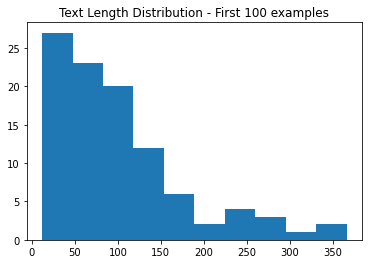

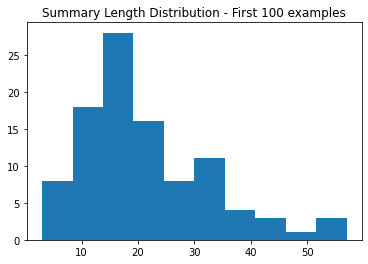

Average Length of text:  100.79
Average Length of Summary:  21.09


In [ ]:
# Use this small dataset to see the length distribution of the texts and corresponding summaries
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution - First 100 examples')
plt.show()

plt.hist(summary_len)
plt.title('Summary Length Distribution - First 100 examples')
plt.show()

print("Average Length of text: ", sum(text_len)/len(text_len))
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

In [ ]:
# Define a function and visualise random parts of the dataset
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(raw_datasets["train"])

,id,dialogue,summary
0,13862887,"Diana: hey, mum called me\nDiana: you know about Adrien???\nHelen: yes\nHelen: he's fine, at home now\nDiana: ok great, I called him but he's not picking up\nHelen: just talked to him, he's okay\nHelen: actually I was just going to call you cause he asked me to tell you he's fine\nHelen: but wants to sleep now\nDiana: is he alone?\nHelen: Chloe is on her way\nHelen: she'll stay with him\nDiana: ok, good\nDiana: how did it happen?\nHelen: don't know exactly, but it wasn't his fault\nHelen: the other guy was drunk!!!\nDiana: omg\nHelen: could have been worse :(\nDiana: don't even think!\nHelen: ok sis let me know if you have any news\nHelen: anytime, even in the middle of the night!\nDiana: ok I will, but don't worry\nHelen: goodnight :*\nDiana: bye, love you :*",Adrien asked Helen to call Diana and tell her that he is doing fine. Chloe will stay with him.
1,13680495,Caron: Hiya jen.. are you still ok to have Luna from next Thurs to Monday?.. my bloody fantastic new car turned out shit.. the cam belt snapped while I was on the way to visit my dad in hospital I'm Coventry.. no the fuckers won't give me my money back so have to wait it out.. I'm pissed right off.. can't do anything cos I've given them 14 days to reply to my letter... just gets worse.. hope you are good and still with new fella.. I can't get to you before Thurs but your welcome for a cuppa if your my way xxx\r\nJenny Morris Sharpei: Hi kar yeah that’s fine Hun xxx\r\nJenny Morris Sharpei: If u want me to pick her up I will Hun xx\r\nCaron: Hiya hun.. I should be ok to bring her over cos Andy will he here with his car xxx\r\nJenny Morris Sharpei: Ok chic xxx\r\nJenny Morris Sharpei: Wot time you coming Thursday Hun ? Xxx\r\nCaron: Hiya not sure yet.. what time are you home or is it easier to pick her up.. and may not be over til later\r\nJenny Morris Sharpei: Anytimes good after 10am as on night shift Wednesday night xx\r\nCaron: Ok chic. I will text you before I come xx\r\nJenny Morris Sharpei: Ok 👍xxxx\r\nCaron: Hiya jen.. can we bring Luna over in about an hour? Xx\r\nJenny Morris Sharpei: Yeah that’s fine Hun xxx\r\nCaron: Cheers babes see you soon x\r\nJenny Morris Sharpei: Xxx👍\r\nCaron: Hiya chic.. what time are you working today?\r\nCaron: We have just docked\r\nJenny Morris Sharpei: Morning I’m on night now but off the rest of day Luna is so lush she really has got attached to me sleeps on my face cuddles up by me won’t let ty by me lol absolute love her she’s so funny xxxx\r\nJenny Morris Sharpei: Luna\r\nCaron: Ahh it will take us a couple of hours to get to glos shall we come straight to you half 10 ish?\r\nJenny Morris Sharpei: Yeah ok chic that’s fine xxxx hope u had a great time xxxxx\r\nCaron: Yes we did see you soon xx\r\nJenny Morris Sharpei: Ok chic xxxx\r\nJenny Morris Sharpei: Hi Hun can I pop next week so we can sit down and right up some things I’ve got to put in place xx\r\nJenny Morris Sharpei: How did she go last night Hun xx\r\nCaron: Hiya yes fine.. she doesn't do stairs so she slept down stairs.. her eyes are quite gunky but I've cleaned with salt water xxx\r\nJenny Morris Sharpei: Ok I’ll bring up the cream xx\r\nCaron: Ok chic x\r\nCaron: Hiya do you want to pop over today and go through this paper work I've done xxx,Caron's car broke down. Jenny Morris Sharpei will have Luna from Thursday to Monday. Caron will bring Luna over with Andy. Caron came back and will pick Luna up around 10:30. Jenny Morris Sharpei will visit Caron next week.
2,13830125,"Preston: are you coming?\r\nDominick: to the extra lessons?\r\nPreston: yeah\r\nDominick: still hesitating\r\nPreston: why?\r\nDominick: i've never had the patience for knitting\r\nDominick: my grandma tried to teach me\r\nDominick: i was hopeless :X\r\nPreston: you haven't tried to learn from ME! xD\r\nDominick: that's a fact :D\r\nPreston: come on, it will be fun\r\nPreston: i'll take some calming herbs ;D\r\nDominick: haahaha ok\r\nDominick: i'll try\r\nPr

In [ ]:
# Load metrics (Rouge scores)
metric = load_metric("rouge")
print(metric)

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [ ]:
# Test scores on fake predictions
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

In [ ]:
# Define model checkpoint
model_checkpoint = "t5-small"
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [ ]:
# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
# Test tokenizer
tokenizer("Hello, this one sentence!")
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [ ]:
# Define max input/output length and pre-process the data
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    # inputs = [prefix + doc for doc in examples["text"]]
    inputs = [prefix + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        # labels = tokenizer(examples["headline"], max_length=max_target_length, truncation=True)
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Check data before pre-processing
# raw_datasets['train']["text"][:2]
raw_datasets['train']["summary"][:100]

['Amanda baked cookies and will bring Jerry some tomorrow.',
 'Olivia and Olivier are voting for liberals in this election. ',
 'Kim may try the pomodoro technique recommended by Tim to get more stuff done.',
 'Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside. ',
 'Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do.',
 "Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.",
 "John didn't show up for class due to some work issues with his boss. Cassandra, his teacher told him which exercises to do, and which chapter to study. They are going to meet up for a beer sometime this week after class. ",
 'Sarah sends James an instrumental song he might like. James knows the song. The brain connects the songs to the context they were played in and 

In [ ]:
# Create pre-processed datasets
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
print(tokenized_datasets["test"])

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 819
})


In [ ]:
# Define model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
# Set hyperparameters
batch_size = 4 # UPDATED from 8
steps = 5000
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-samsum_trained_t5_model",
    evaluation_strategy = "steps",
    logging_steps = steps,
    logging_first_step = True,
    save_steps = steps,
    eval_steps = steps,
    learning_rate=3e-4, # UPDATED from 2e-5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
# Collate data
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
data_collator

In [ ]:
# Define function to calculate metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Define trainer
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/bubblecookie/t5-small-finetuned-cnndm_3epoch_v2 into local empty directory.
Using amp half precision backend


In [ ]:
# Train model
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14732
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11049


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
5000,1.888900,1.676085,44.969500,21.918200,37.600700,41.299500,17.073300
10000,1.617600,1.629130,45.971500,23.244200,38.973100,42.505800,16.658900


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 4
Saving model checkpoint to t5-small-finetuned-cnndm_3epoch_v2/checkpoint-5000
Configuration saved in t5-small-finetuned-cnndm_3epoch_v2/checkpoint-5000/config.json
Model weights saved in t5-small-finetuned-cnndm_3epoch_v2/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnndm_3epoch_v2/checkpoint-5000/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnndm_3epoch_v2/checkpoint-5000/special_tokens_map.json
tokenizer config file saved in t5-small-finetuned-cnndm_3epoch_v2/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnndm_3epoch_v2/special_tokens_map.json
The f

TrainOutput(global_step=11049, training_loss=1.7333889649091063, metrics={'train_runtime': 1439.2477, 'train_samples_per_second': 30.708, 'train_steps_per_second': 7.677, 'total_flos': 3177327483027456.0, 'train_loss': 1.7333889649091063, 'epoch': 3.0})

In [ ]:
# Save model checkpoints on HuggingFace hub
trainer.push_to_hub()